# Image Captioning using Flicker8k data set

In [3]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow.keras.applications.inception_v3 import  InceptionV3, preprocess_input
from  tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from  tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from nltk.translate.bleu_score import corpus_bleu


**Dataset Overview**:
The Flickr8k dataset serves as a benchmark for sentence-based image description and retrieval. It includes:
-	8,000 Images: Each image is paired with five distinct captions.
-	Image Sources: Images are sourced from six different Flickr groups, depicting a diverse range of scenes and scenarios.
-	Content Focus: The images intentionally exclude well-known people or landmarks to emphasize general scene descriptions.


Loading Dataset from Kaggle

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [01:01<00:00, 21.0MB/s]
100% 1.04G/1.04G [01:01<00:00, 18.0MB/s]


In [4]:
!unzip /content/flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [5]:
img_dir = '/content/Images'

Creating Dictionary from the dataset

In [6]:
def load_captions(filename):         #Loads captions and maps them to thier respective images
  with open(filename) as f:
    next(f)
    caption_data = f.readlines()
    caption_mapping = {}
    captions_text = []
    text_data=[]
    skipped = set()
    for line in caption_data:
      print("Input: ",line)
      line= line.rstrip("\n")
      img_name, caption_text = line.split(',',1)
      img_name = os.path.join(img_dir,img_name.strip())
      caption_text = caption_text.lower()
      caption_text = re.sub(r'[^\w\s]','', caption_text)
      caption_text = re.sub('\s+',' ',caption_text)
      caption_text = caption_text.strip()
      #caption_text =caption_text.replace('"','')
      tokens = caption_text.strip().split()
      print("output: ",img_name, " :  ",caption_text)

      if len(tokens ) > 5  :
        if img_name.endswith("jpg"):
          text_data.append(caption_text.strip())
          cap = "start " + caption_text.strip() + " end"
          if img_name in caption_mapping:
            caption_mapping[img_name].append(cap)
          else:
            caption_mapping[img_name] = [cap]
  return caption_mapping,text_data

In [7]:
cap_data,text_data = load_captions("/content/captions.txt")

Streaming output truncated to the last 5000 lines.

output:  /content/Images/566794440_f9ec673a2f.jpg  :   a woman with a glove on a baseball field with another woman
Input:  566794440_f9ec673a2f.jpg,The girls return to the field during their softball game .

output:  /content/Images/566794440_f9ec673a2f.jpg  :   the girls return to the field during their softball game
Input:  566921157_07c18a41e2.jpg,A brown and a brown dog are running .

output:  /content/Images/566921157_07c18a41e2.jpg  :   a brown and a brown dog are running
Input:  566921157_07c18a41e2.jpg,Two dogs running in the dirt

output:  /content/Images/566921157_07c18a41e2.jpg  :   two dogs running in the dirt
Input:  566921157_07c18a41e2.jpg,Two dogs running over packed dirt and rocks

output:  /content/Images/566921157_07c18a41e2.jpg  :   two dogs running over packed dirt and rocks
Input:  566921157_07c18a41e2.jpg,Two dogs run through mud .

output:  /content/Images/566921157_07c18a41e2.jpg  :   two dogs run through mud


In [8]:
len(text_data)

38603

We have 38,603 caption for 8K images

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(sen.split()) for sen in text_data)

In [10]:
print("Max_len of caption is : ", max_len, " and Vocab size or uninque number of words are : ", vocab_size)

Max_len of caption is :  36  and Vocab size or uninque number of words are :  8710


Getting Image Features for Captioning

In [65]:
#del model

In [11]:
base_model =InceptionV3()
model = Model(inputs = base_model.inputs, outputs=base_model.layers[-2].output )

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [13]:
img_features={}
for img_path in tqdm(os.listdir(img_dir)):
  img_name = os.path.join(img_dir, img_path)
  #print(img_name)
  img= load_img(img_name, target_size = (299,299))
  img = img_to_array(img)
  img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
  image = preprocess_input(img)
  #print(model.predict(image, verbose = 0))
  f= model.predict(image, verbose=0)
  img_features[img_name] = f

  0%|          | 0/8091 [00:00<?, ?it/s]

Saving Features using Pickle

In [14]:
pickle.dump(img_features, open(os.path.join('/content/', 'features.pkl'), 'wb'))

Splitting Data to train and test

In [15]:
def train_test_split(cap_dict, train_size = 0.8, shuffle =True):
  img_all = list(cap_dict.keys())
  if shuffle:
    np.random.shuffle(img_all)
  t_size =int(len(cap_dict.keys())* train_size)
  test_size = len(cap_dict.keys())- t_size
  print("Splitting  dataset: We now have ", t_size, " of 8091 to train and ", test_size," to test after splitting ")

  train_data = {img_name : cap_dict[img_name] for img_name in img_all[:t_size]}
  test_data = {img_name : cap_dict[img_name] for img_name in img_all[t_size:]}
  return train_data, test_data

In [16]:
train_data, test_data = train_test_split(cap_data)

Splitting  dataset: We now have  6472  of 8091 to train and  1619  to test after splitting 


Creating data generator

In [17]:
def datagenerator(caption_dict, features_dict, tokenizer, max_len, vocab_size, batch_size):
  X1, X2, y = [], [], []
  k=0
  while True:
    for img in caption_dict.keys():
      k+=1
      captions = caption_dict[img]
      for cap in captions:
        seq = tokenizer.texts_to_sequences([cap])[0]
        for i in range (1,len(seq)):
          input_seq, output_seq = seq[:i], seq[i]
          input_seq = pad_sequences([input_seq],padding='post', maxlen = max_len)[0]
          output_seq = to_categorical([output_seq], num_classes = vocab_size)[0]
          X1.append(features_dict[img][0])
          X2.append(input_seq)
          y.append(output_seq)

      if k==batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield (X1, X2), y
        X1, X2, y = [], [], []
        k=0

Model Creation

This model can only work with data present in train and test data. if user input is requried we need create another function to take user image and extract features pof the image using vgg top model.

Encoder Part (Image input and Caption input )

In [18]:
input_enc_1 = tf.keras.Input(shape=(2048,))
lay_img_1 = tf.keras.layers.Dropout(0.5)(input_enc_1)
lay_img_2 = tf.keras.layers.Dense(256, activation = 'relu')(lay_img_1)

input_enc_2 = tf.keras.Input(shape=(max_len,))
rnn_1 = tf.keras.layers.Embedding(vocab_size, 256, mask_zero=True)(input_enc_2)
rnn_2 = tf.keras.layers.Dropout(0.5)(rnn_1)
rnn_3 = tf.keras.layers.LSTM(256)(rnn_2)

Decoder Part (Combining Two Models)

In [19]:
concat_model_1 = tf.keras.layers.add([lay_img_2,rnn_3])
concat_model_2 =  tf.keras.layers.Dense(256, activation = 'relu')(concat_model_1)
concat_model_output = tf.keras.layers.Dense(vocab_size, activation = 'softmax')(concat_model_2)

final_model = Model(inputs = [input_enc_1, input_enc_2], outputs=concat_model_output )
final_model.compile(loss='categorical_crossentropy', optimizer='adam')

Plotting the Final Combined Model

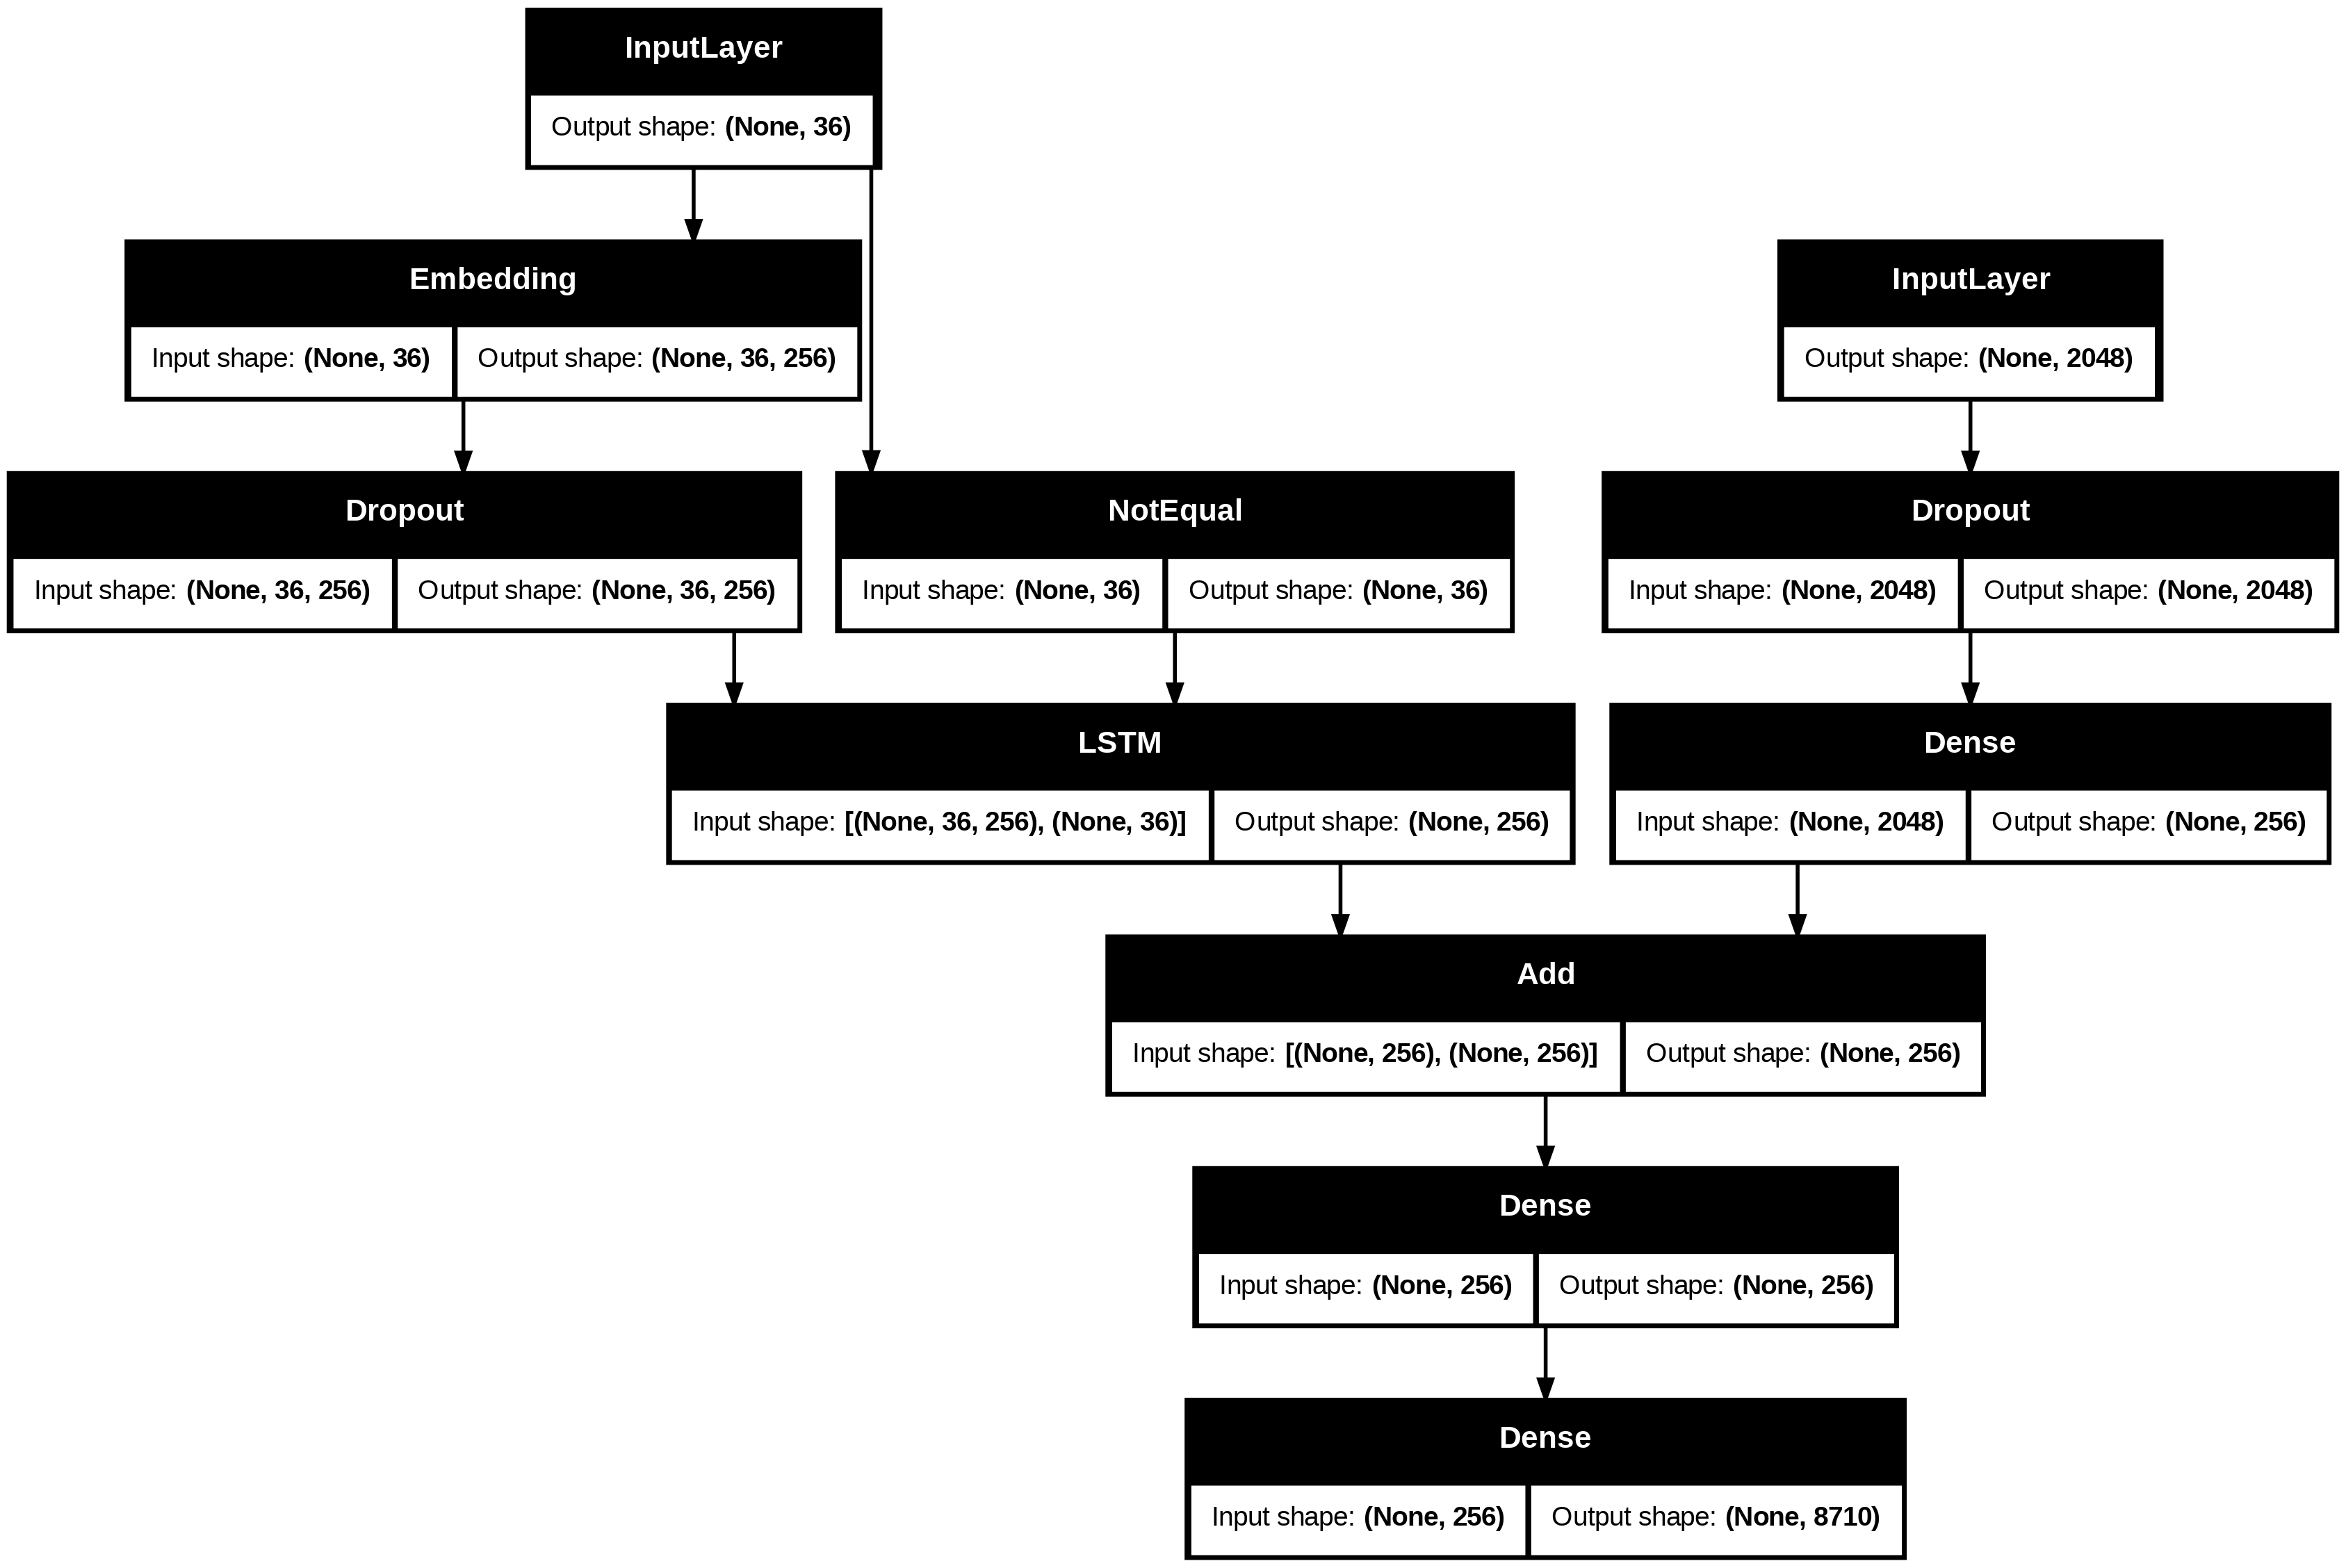

In [20]:
plot_model(final_model, show_shapes=True)

Training the model

In [21]:
epochs = 10
batch_size = 32
steps = len(train_data)//batch_size

for i in range(epochs):
  generator = datagenerator(train_data, img_features, tokenizer, max_len, vocab_size,batch_size)
  final_model.fit(generator, epochs =1 , steps_per_epoch = steps, verbose =1)

202/202 ━━━━━━━━━━━━━━━━━━━━ 69s 314ms/step - loss: 5.6576
202/202 ━━━━━━━━━━━━━━━━━━━━ 62s 308ms/step - loss: 3.7340
202/202 ━━━━━━━━━━━━━━━━━━━━ 61s 303ms/step - loss: 3.2804
202/202 ━━━━━━━━━━━━━━━━━━━━ 63s 311ms/step - loss: 3.0461
202/202 ━━━━━━━━━━━━━━━━━━━━ 61s 304ms/step - loss: 2.8868
202/202 ━━━━━━━━━━━━━━━━━━━━ 62s 307ms/step - loss: 2.7651
202/202 ━━━━━━━━━━━━━━━━━━━━ 63s 310ms/step - loss: 2.6627
202/202 ━━━━━━━━━━━━━━━━━━━━ 62s 309ms/step - loss: 2.5754
202/202 ━━━━━━━━━━━━━━━━━━━━ 62s 309ms/step - loss: 2.5011
202/202 ━━━━━━━━━━━━━━━━━━━━ 63s 315ms/step - loss: 2.4388


In [22]:
model.save('/content/'+'final_model.h5')

Testing and Generating captions for the images

In [23]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [28]:
def predicted_captions(model, image, tokenizer, max_len):
  pred_text = '<start>'
  for i in range(max_len):
    seq = tokenizer.texts_to_sequences([pred_text])[0]
    seq = pad_sequences([seq], padding='post',maxlen = max_len)
    pred = model.predict([image, seq], verbose=0)
    pred = np.argmax(pred)
    word = idx_to_word(pred, tokenizer)
    if word is None:
      break
    pred_text += " " + word
    if word == 'end':
      break
  return pred_text

Evaluating bleu score

In [29]:
actual_cap, pred_cap=[],[]
for i in tqdm(test_data):
  cap = test_data[i]
  pred = predicted_captions(final_model, img_features[i], tokenizer, max_len)
  actual_cap.append([c.split() for c in cap])
  pred_cap.append(pred.split())

print("Bleu-1: %f" % corpus_bleu(actual_cap, pred_cap, weights=(1.0, 0, 0, 0)))
print("Bleu-2: %f" % corpus_bleu(actual_cap, pred_cap, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1619 [00:00<?, ?it/s]

Bleu-1: 0.551855
Bleu-2: 0.348027


Visualizing the Results

In [34]:
def caption_test(img_name,test_data):
  img_path = os.path.join(img_dir, img_name)
  img = Image.open(img_path)
  captions = test_data[img_name]
  print("Actual :----------------------------------     ")
  for cap in captions:
    cap = cap.replace('start','')
    cap = cap.replace('end','')
    print(cap)
  print("Predicted :-----------------------------")
  pred_cap = predicted_captions(final_model, img_features[img_name], tokenizer, max_len)
  pred_cap = pred_cap.replace('start','')
  pred_cap = pred_cap.replace('end','')
  print(pred_cap)
  plt.imshow(img)

Actual :----------------------------------     
 a man dressed in camouflage riding a motorbike 
 a man is going between two red flag markers on a dirt bike 
 a man is riding a dirt bike over some rocks 
 a man wearing camouflage steers a motorcycle across some stones 
 the man waeribng a helmet is riding a dirt bike over rocks 
Predicted :-----------------------------
<> a man is riding a bike on a hill 


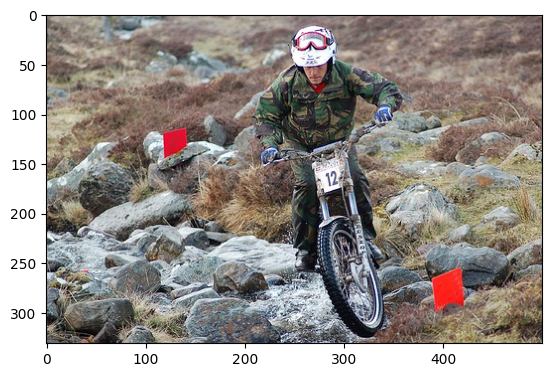

In [38]:
import random
img_name = random.choice(list(test_data.keys()))
caption_test(img_name, test_data)

Actual :----------------------------------     
 a boy wearing a black and blue life vest is on a green wooden boat looking out towards the water 
 a boy wearing a blue life jacket is holding onto the side of a green boat 
 a child holds on to the side of a small weathered green watercraft on the open sea 
 a little boy in a life vest is looking out the side of a boat 
 a young boy riding in a green boat 
Predicted :-----------------------------
<> a boy in a blue swimsuit is jumping into the water 


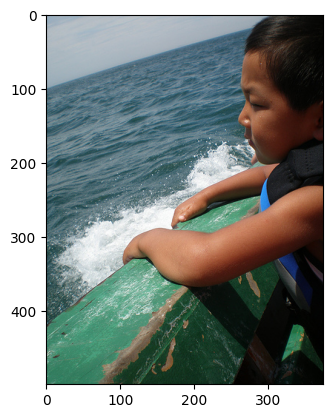

In [42]:
img_name = random.choice(list(test_data.keys()))
caption_test(img_name, test_data)

Actual :----------------------------------     
 a man in yellow sits on a rock ledge overlooking a forest 
 a person in a yellow raincoat is sitting on the edge of a rock looking down 
 a person in a yellow raincoat seating on a cliff 
 a person is sitting on the edge of a rock cliff 
 a person sitting on the edge of a rock outcropping looking down 
Predicted :-----------------------------
<> a man is climbing a steep rock cliff 


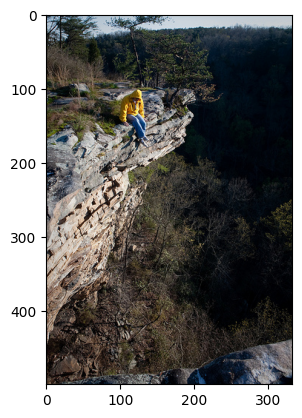

In [44]:
img_name = random.choice(list(test_data.keys()))
caption_test(img_name, test_data)

Actual :----------------------------------     
 a person snowboarding down a snowy hill 
 a snowboarder is coming down a hill 
 person snowboarding down a snow covered slope 
 someone is snowboarding down a hill shredding snow 
 the man is snowboarding down a snowy hill 
Predicted :-----------------------------
<> a person snowboarding on a snowy hill 


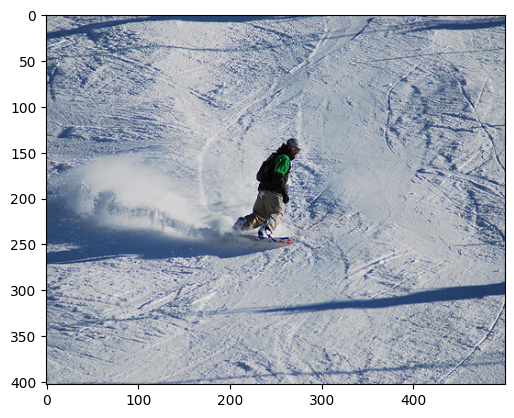

In [45]:
img_name = random.choice(list(test_data.keys()))
caption_test(img_name, test_data)

Actual :----------------------------------     
 a big tan dog drinks water from an outdoor water spout 
 a closeup of a white dog drinking from a pipe 
 a white dog in a brown collar drinking from a spigot 
 a white puppy is drinking water from a tap attached to a white wall 
 the dog is drinking water from a fountain 
Predicted :-----------------------------
<> a dog is running through a stream 


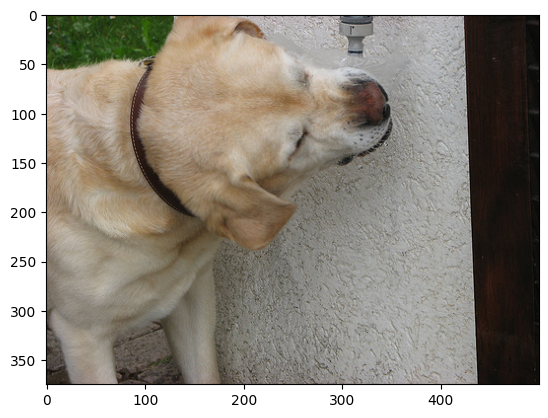

In [48]:
img_name = random.choice(list(test_data.keys()))
caption_test(img_name, test_data)